In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org=pd.read_csv('house_price.csv')
house_df=house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [2]:
print('데이터 세트의 Shape:',house_df.shape)
print('\n전체 피처의 type \n',house_df.dtypes.value_counts())
isnull_series=house_df.isnull().sum()
print('\nNull 칼럼과 그 건수: \n',isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수: 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


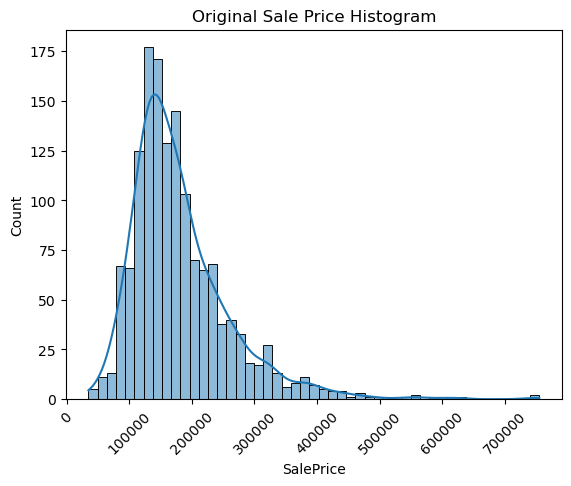

In [3]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'],kde=True)
plt.show()

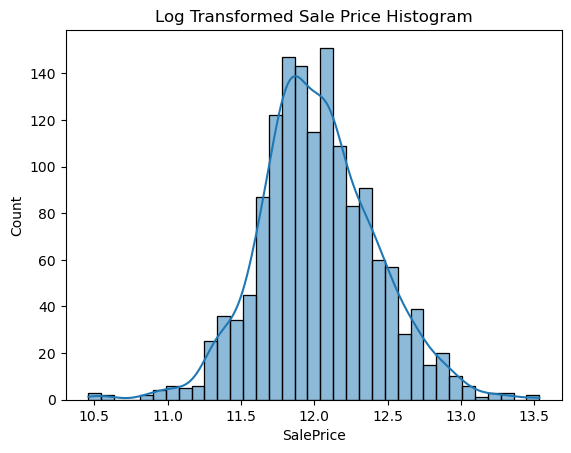

In [4]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice=np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice,kde=True)
plt.show()

In [5]:
original_SalePrice=house_df['SalePrice']
house_df['SalePrice']=np.log1p(house_df['SalePrice'])
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)
house_df.fillna(house_df.mean(numeric_only=True), inplace=True)
null_column_count=house_df.isnull().sum()[house_df.isnull().sum()>0]
print('Null 피처의 Type :\n',house_df.dtypes[null_column_count.index])

Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [6]:
house_df_ohe=pd.get_dummies(house_df)

In [7]:
def get_rmse(model):
    pred=model.predict(X_test)
    mse=mean_squared_error(y_test,pred)
    rmse=np.sqrt(mse)
    print(model.__class__.__name__,'RMSE:', np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses=[]
    for model in models:
        rmse=get_rmse(model)
        rmses.append(rmse)
    return rmses

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.2,random_state=156)

lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg=Ridge()
ridge_reg.fit(X_train,y_train)
lasso_reg=Lasso()
lasso_reg.fit(X_train,y_train)

models=[lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

LinearRegression RMSE: 0.132
Ridge RMSE: 0.128
Lasso RMSE: 0.176


[0.13189576579154003, 0.12750846334053043, 0.17628250556471395]

In [9]:
def get_top_bottom_coef(model,n=10):
    coef=pd.Series(model.coef_,index=X_features.columns)
    coef_high=coef.sort_values(ascending=False).head(n)
    coef_low=coef.sort_values(ascending=False).tail(n)
    return coef_high,coef_low

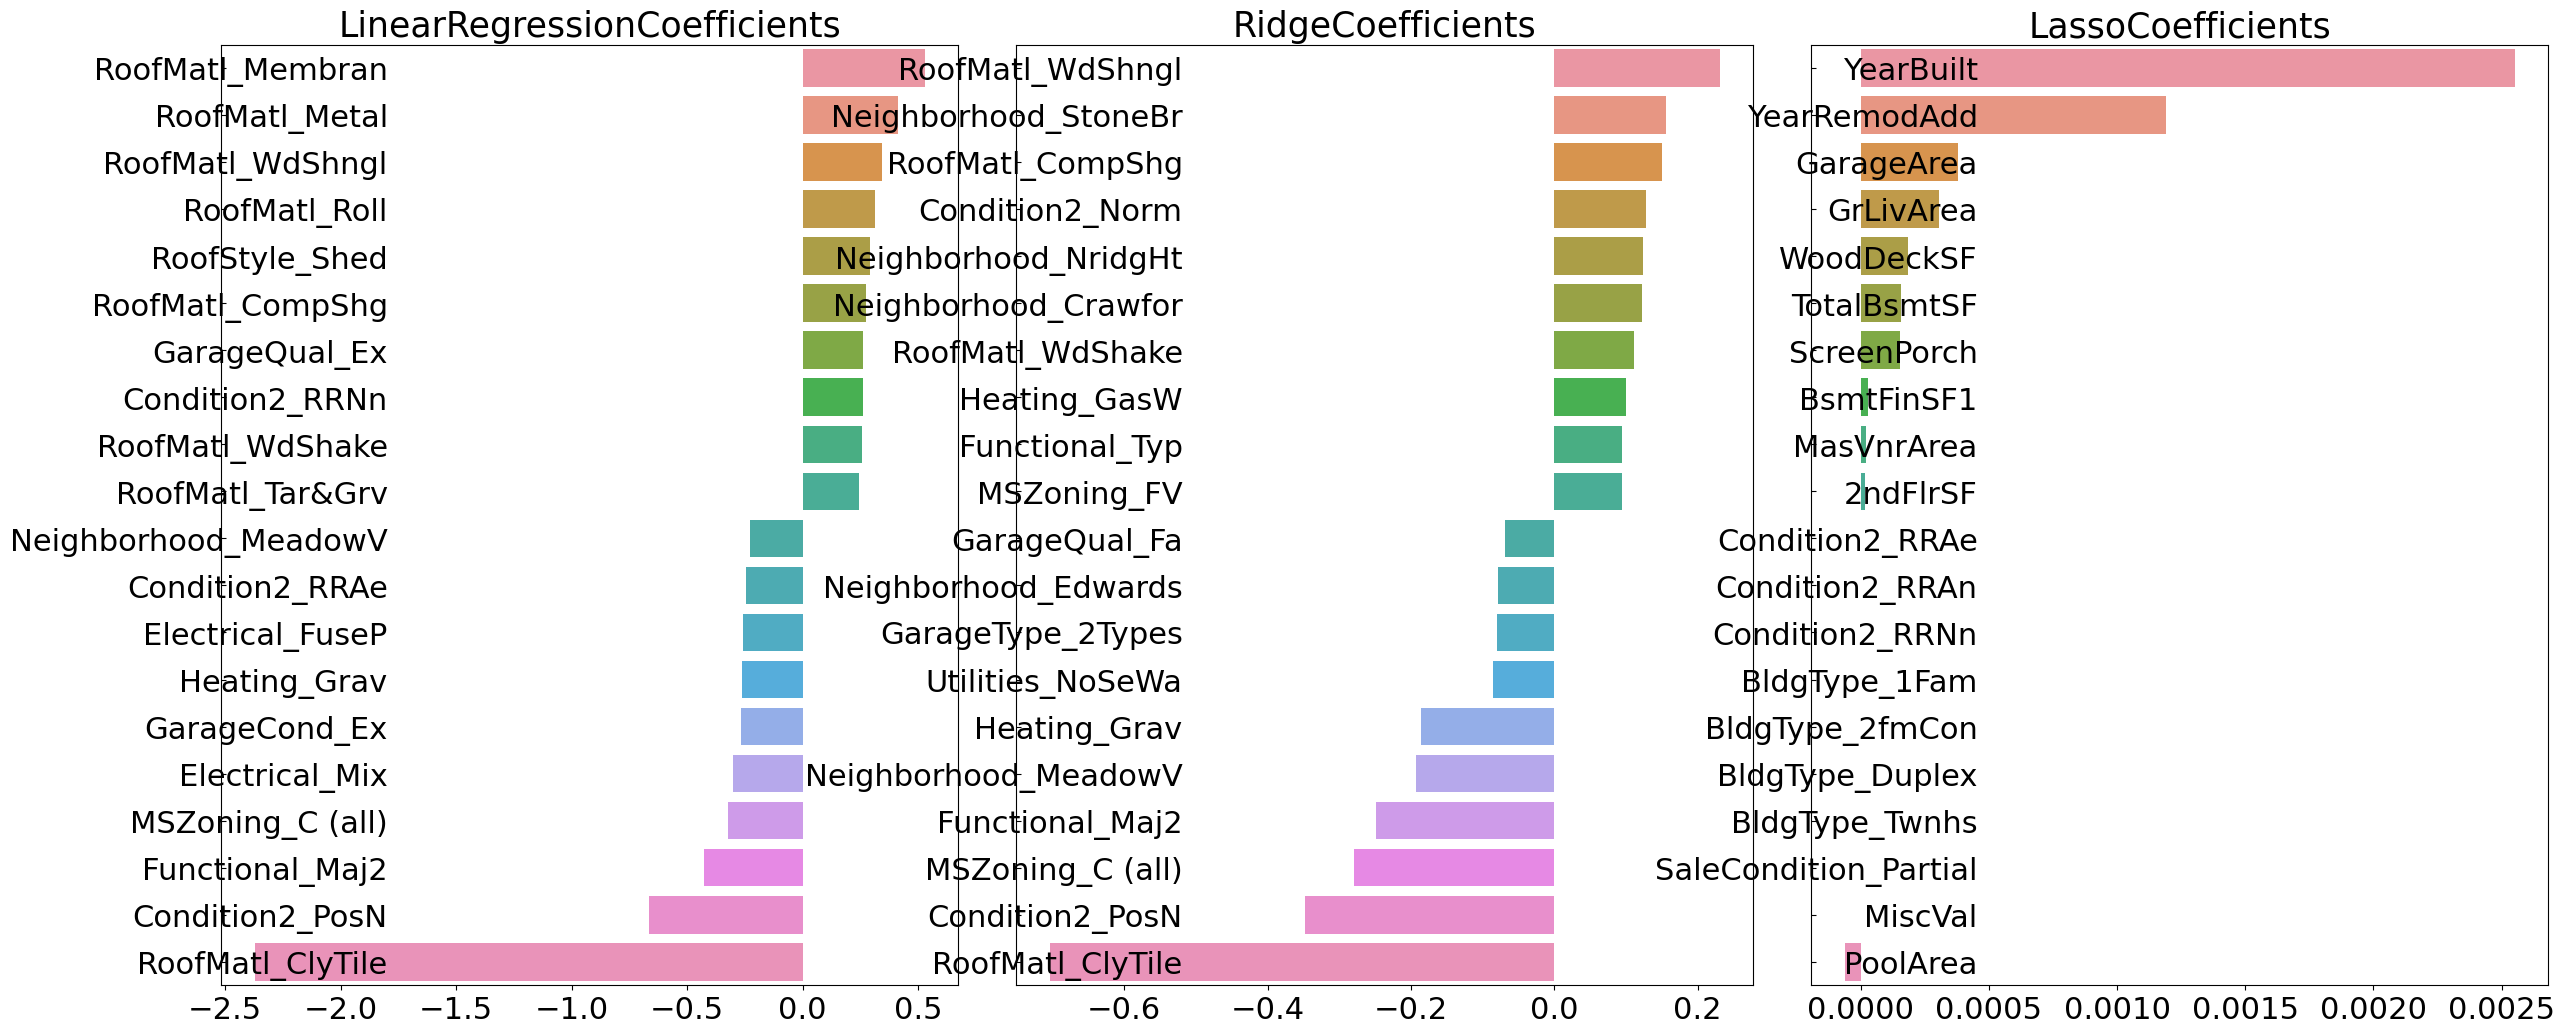

In [10]:
def visualize_coefficient(models):
    fig,axs=plt.subplots(figsize=(24,10),nrows=1,ncols=3)
    fig.tight_layout()
    
    for i_num,model in enumerate(models):
        coef_high,coef_low=get_top_bottom_coef(model)
        coef_concat=pd.concat([coef_high,coef_low])
        
        axs[i_num].set_title(model.__class__.__name__+'Coefficients',size=25)
        axs[i_num].tick_params(axis="y",direction="in",pad=-120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values,y=coef_concat.index,ax=axs[i_num])
        
models=[lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

In [11]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list=np.sqrt(-cross_val_score(model,X_features,y_target,scoring="neg_mean_squared_error",cv=5))
        rmse_avg=np.mean(rmse_list)
        print('{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__,np.round(rmse_list,3)))
        print('\n{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__,np.round(rmse_avg,3)))
        
models=[ridge_reg,lasso_reg]
get_avg_rmse_cv(models)

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]

Ridge CV 평균 RMSE 값: 0.144
Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]

Lasso CV 평균 RMSE 값: 0.198


In [11]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model,params):
    grid_model=GridSearchCV(model,param_grid=params,scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X_features,y_target)
    rmse=np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 알파:{2}'.format(model.__class__.__name__,np.round(rmse,4),grid_model.best_params_))

ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 알파:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 알파:{'alpha': 0.001}


LinearRegression RMSE: 0.132
Ridge RMSE: 0.124
Lasso RMSE: 0.12


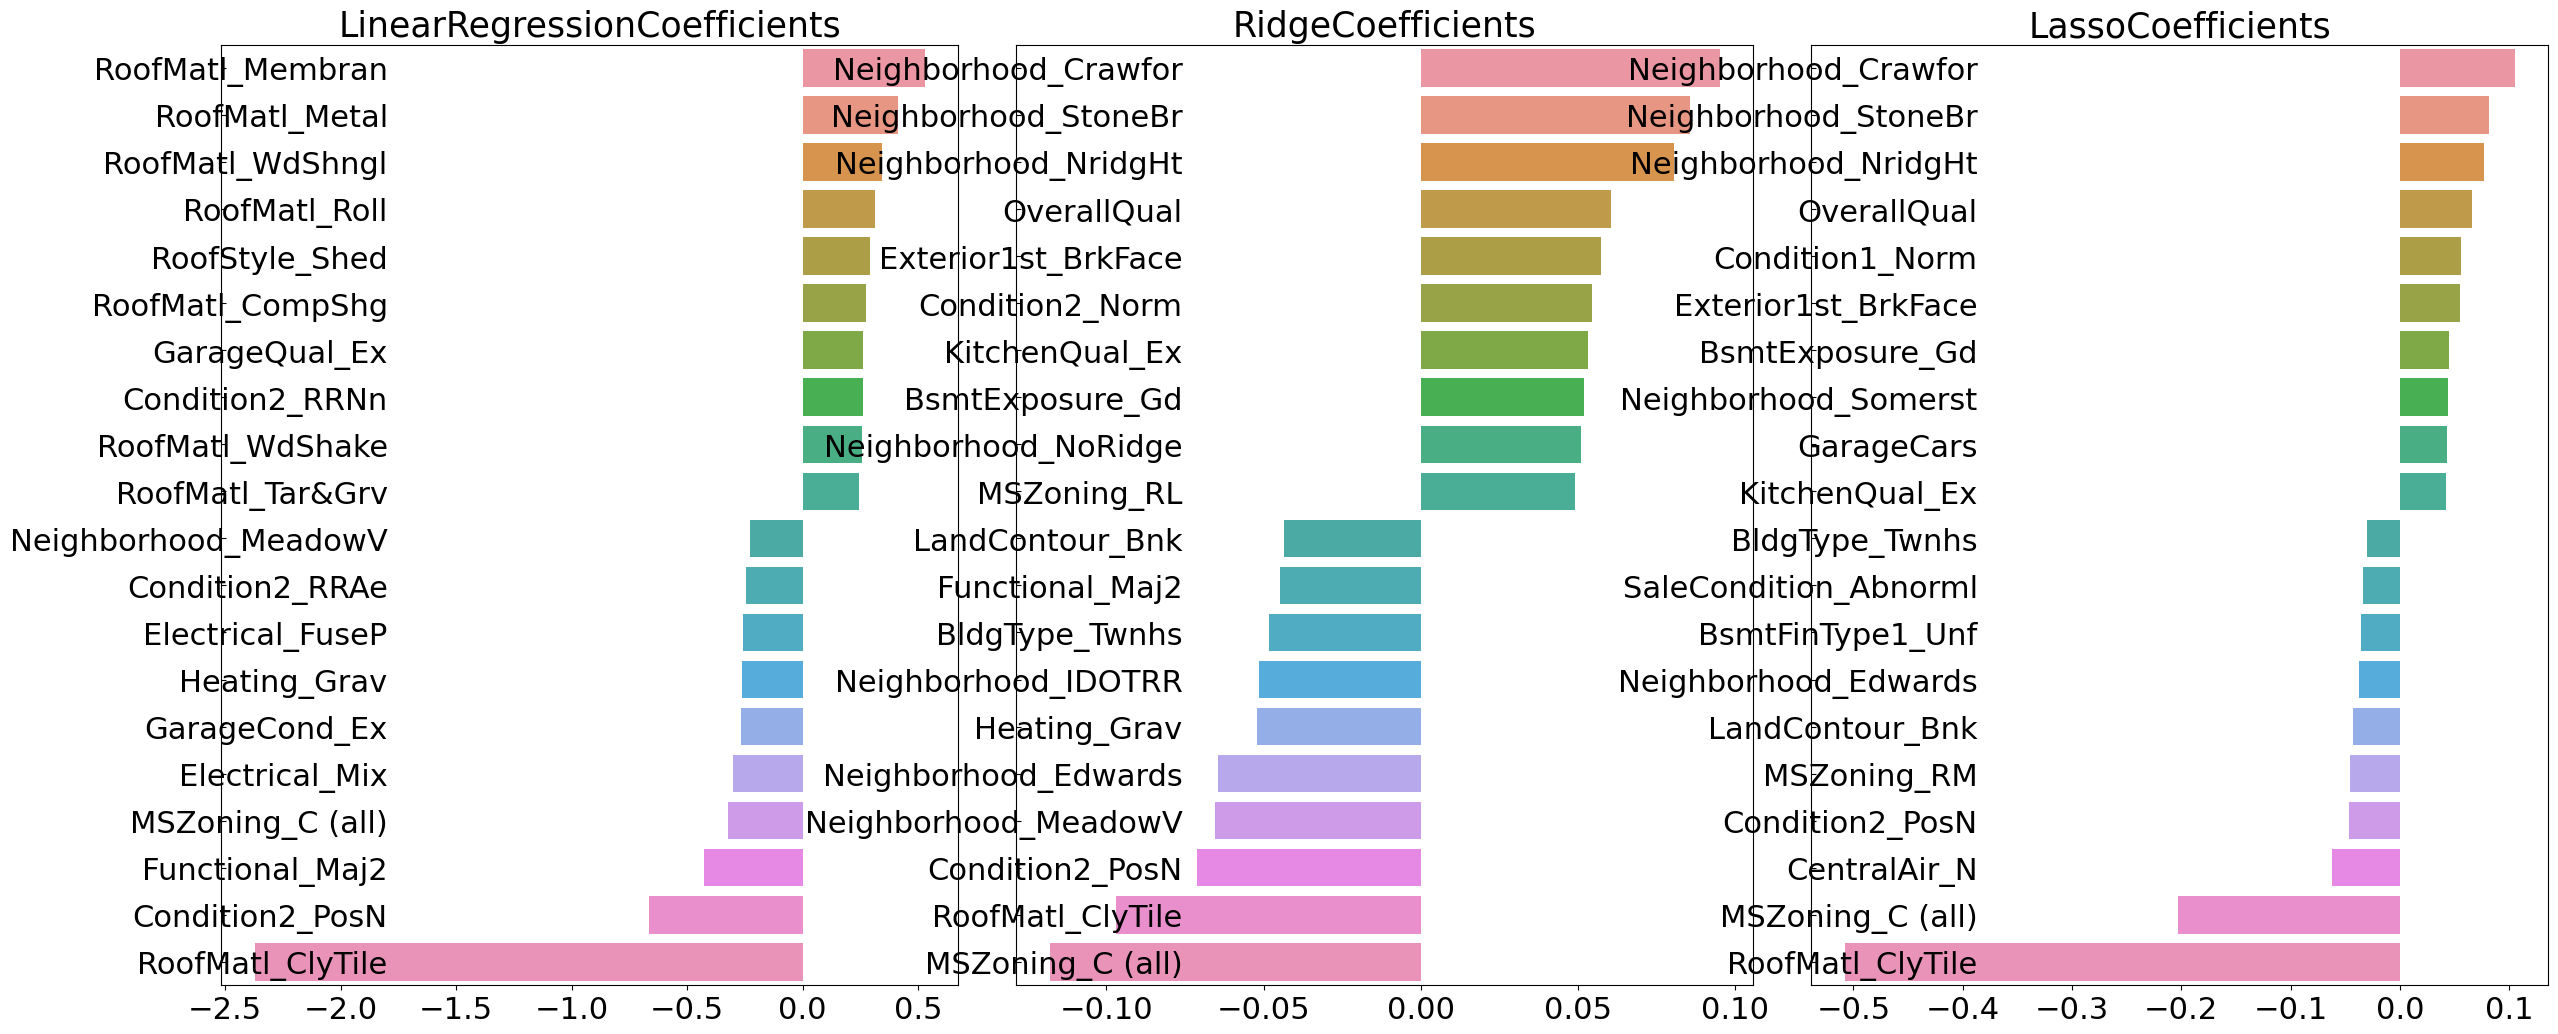

In [12]:
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg=Ridge(alpha=12)
ridge_reg.fit(X_train,y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

models=[lr_reg,ridge_reg,lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [13]:
from scipy.stats import skew

features_index=house_df.dtypes[house_df.dtypes!='object'].index
skew_features=house_df[features_index].apply(lambda x:skew(x))
skew_features_top=skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [14]:
house_df[skew_features_top.index]=np.log1p(house_df[skew_features_top.index])

In [15]:
house_df_ohe=pd.get_dummies(house_df)
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.2,random_state=156)

ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 알파:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 알파:{'alpha': 0.001}


LinearRegression RMSE: 0.128
Ridge RMSE: 0.122
Lasso RMSE: 0.119


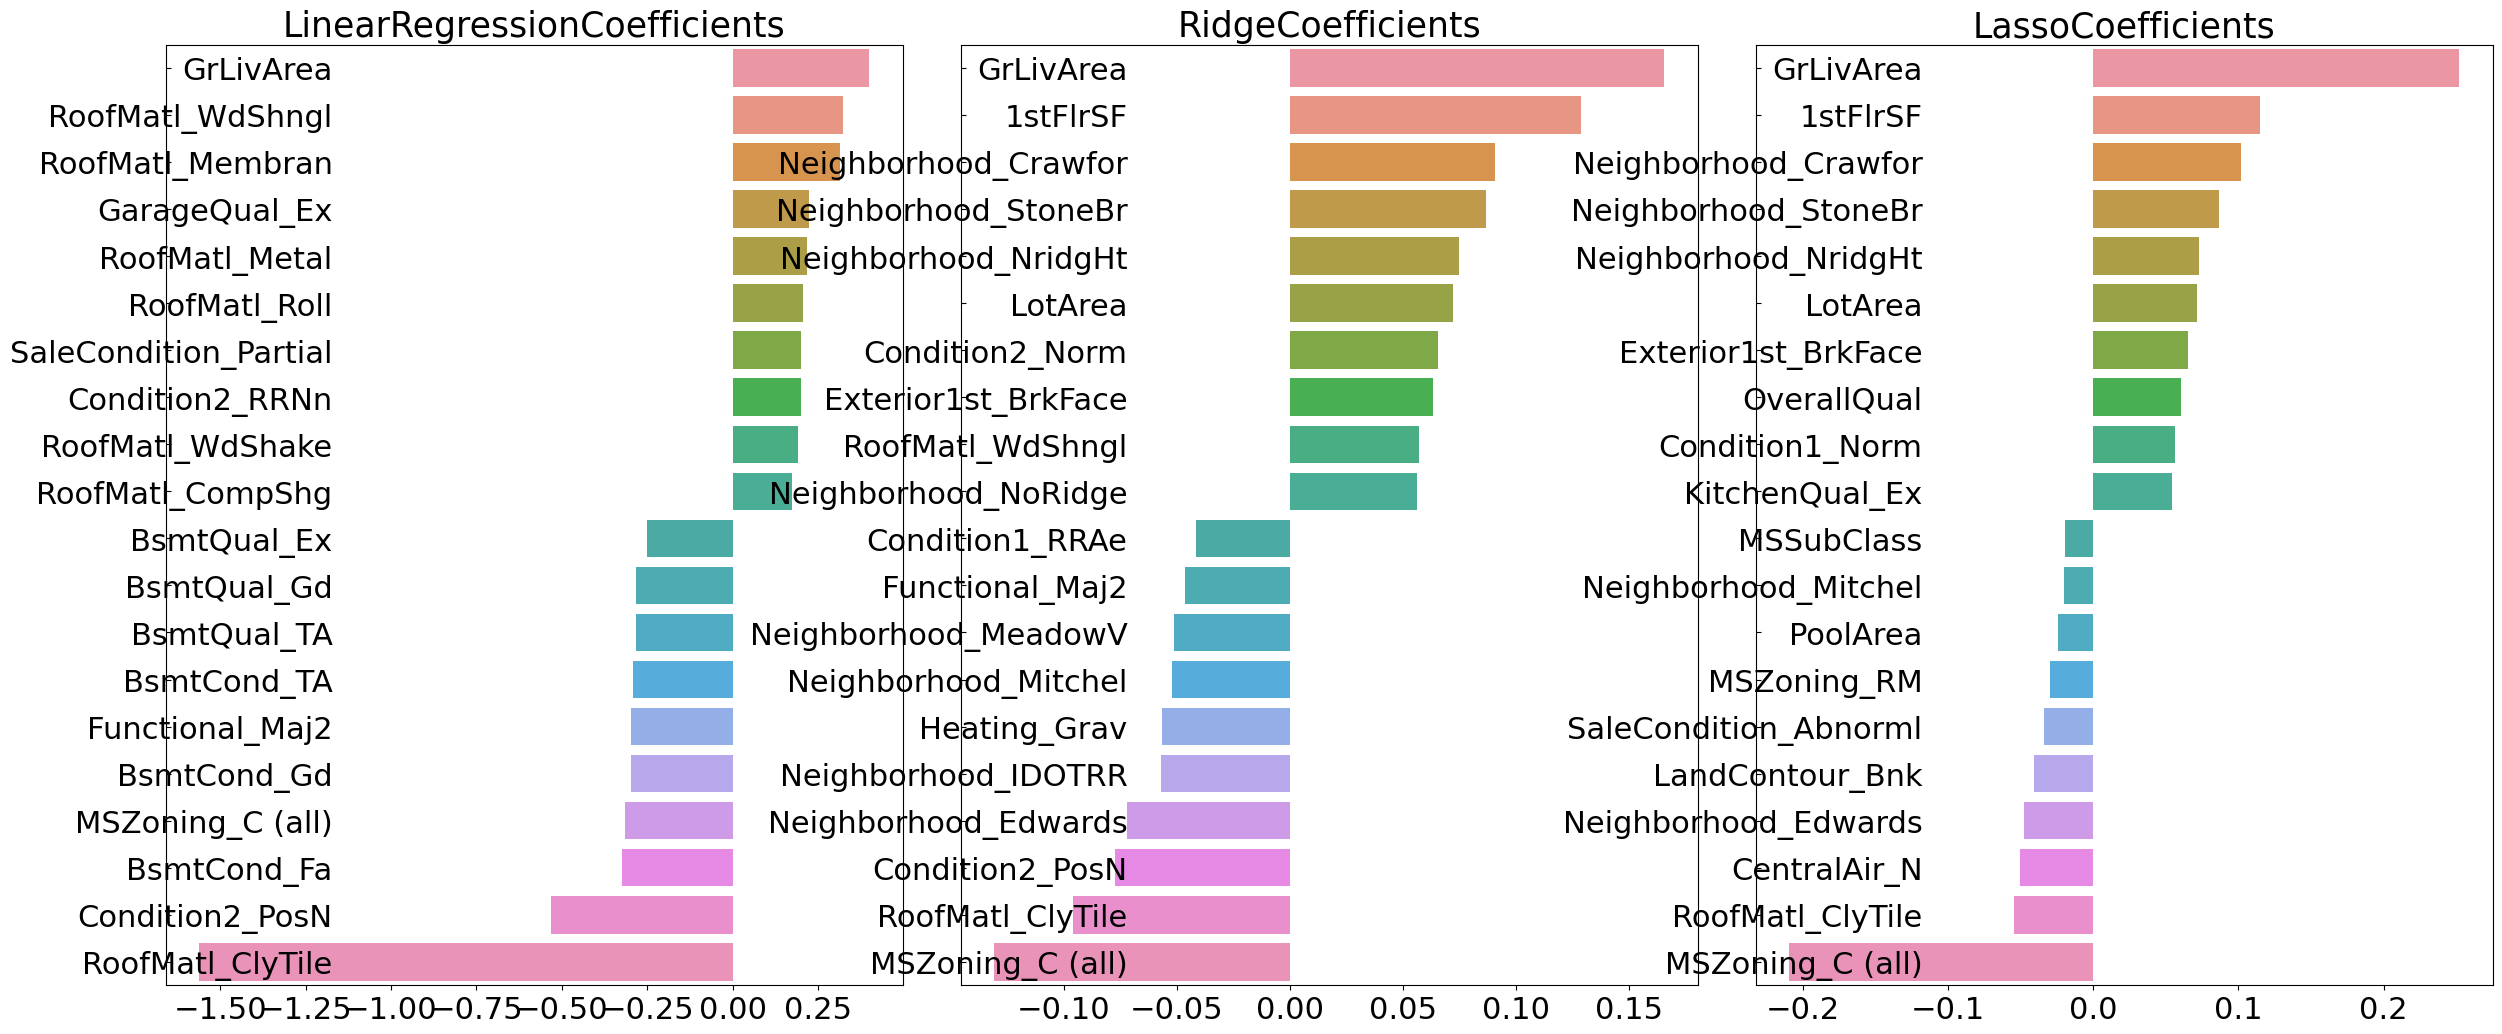

In [16]:
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg=Ridge(alpha=10)
ridge_reg.fit(X_train,y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

models=[lr_reg,ridge_reg,lasso_reg]
get_rmses(models)
visualize_coefficient(models)

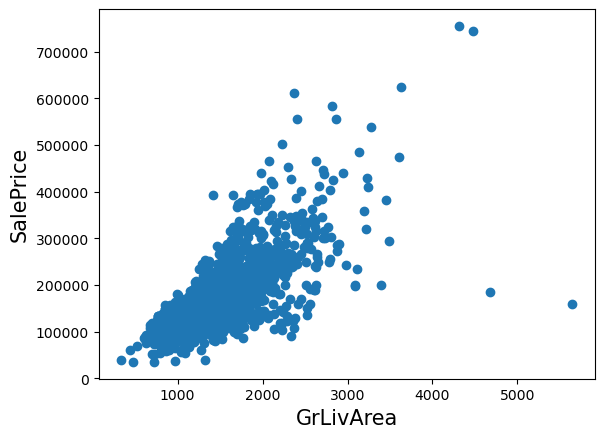

In [17]:
plt.scatter(x=house_df_org['GrLivArea'],y=house_df_org['SalePrice'])
plt.ylabel('SalePrice',fontsize=15)
plt.xlabel('GrLivArea',fontsize=15)
plt.show()

In [18]:
cond1=house_df_ohe['GrLivArea']>np.log1p(4000)
cond2=house_df_ohe['SalePrice']<np.log1p(500000)
outlier_index=house_df_ohe[cond1&cond2].index
print('이상치 레코드 index:',outlier_index.values)

이상치 레코드 index: [ 523 1298]


In [19]:
house_df_ohe.drop(outlier_index,axis=0,inplace=True)

In [20]:
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.2,random_state=156)
ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg,ridge_params)
print_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 알파:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 알파:{'alpha': 0.001}


LinearRegression RMSE: 0.129
Ridge RMSE: 0.103
Lasso RMSE: 0.1


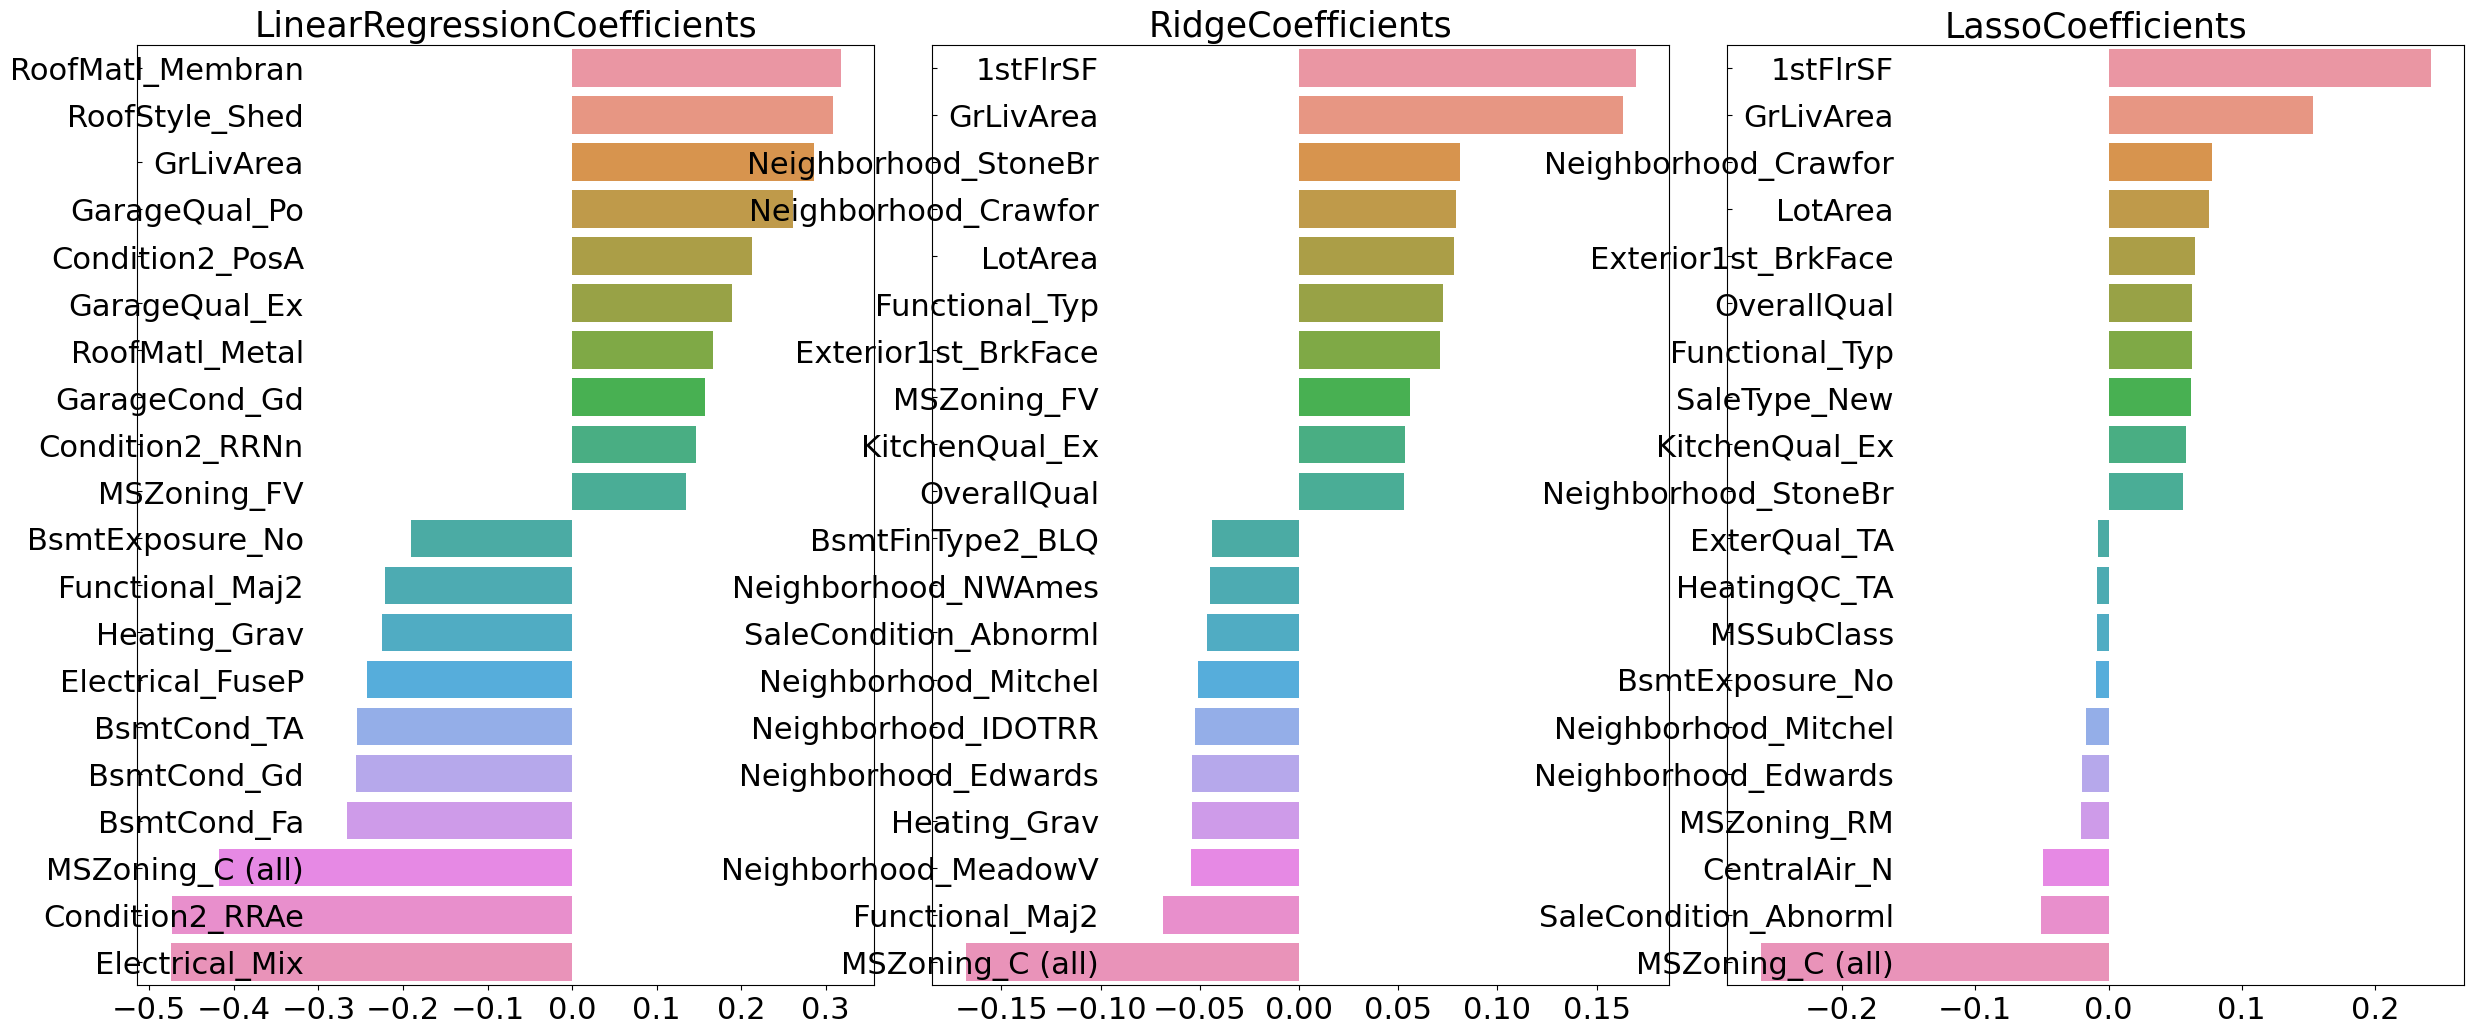

In [21]:
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg=Ridge(alpha=8)
ridge_reg.fit(X_train,y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

models=[lr_reg,ridge_reg,lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [29]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

xgb_reg=XGBRegressor(n_estimators=1000,learning_rate=0.05,colsample_bytree=0.5,subsample=0.8)
lgbm_reg=LGBMRegressor(n_estimators=1000,learning_rate=0.05,num_leaves=4,subsample=0.6,colsample_bytree=0.4,reg_lambda=10,n_jobs=-1,force_col_wise=True)

def get_stacking_base_datasets(model,X_train_n,y_train_n,X_test_n,n_folds):
    kf=KFold(n_splits=n_folds,shuffle=False)
    train_fold_pred=np.zeros((X_train_n.shape[0],1))
    test_pred=np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__,' model 시작')
    
    for folder_counter,(train_index,valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작')
        X_tr=X_train_n[train_index]
        y_tr=y_train_n[train_index]
        X_te=X_train_n[valid_index]
        
        model.fit(X_tr,y_tr)
        train_fold_pred[valid_index,:]=model.predict(X_te).reshape(-1,1)
        test_pred[:,folder_counter]=model.predict(X_test_n)
        
    test_pred_mean=np.mean(test_pred,axis=1).reshape(-1,1)
    
    return train_fold_pred,test_pred_mean

X_train_n=X_train.values
X_test_n=X_test.values
y_train_n=y_train.values

ridge_train,ridge_test=get_stacking_base_datasets(ridge_reg,X_train_n,y_train_n,X_test_n,5)
lasso_train,lasso_test=get_stacking_base_datasets(lasso_reg,X_train_n,y_train_n,X_test_n,5)
xgb_train,xgb_test=get_stacking_base_datasets(xgb_reg,X_train_n,y_train_n,X_test_n,5)
lgbm_train,lgbm_test=get_stacking_base_datasets(lgbm_reg,X_train_n,y_train_n,X_test_n,5)

Stack_final_X_train=np.concatenate((ridge_train,lasso_train,xgb_train,lgbm_train),axis=1)
Stack_final_X_test=np.concatenate((ridge_test,lasso_test,xgb_test,lgbm_test),axis=1)

meta_model_lasso=Lasso(alpha=0.0005)

meta_model_lasso.fit(Stack_final_X_train,y_train)
final=meta_model_lasso.predict(Stack_final_X_test)
mse=mean_squared_error(y_test,final)
rmse=np.sqrt(mse)
print('\n스태킹 회귀 모델의 최종 RMSE 값은: ', rmse)

Ridge  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
Lasso  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
XGBRegressor  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
LGBMRegressor  model 시작
	 폴드 세트:  0  시작
[LightGBM] [Info] Total Bins 2926
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 157
[LightGBM] [Info] Start training from score 12.035561
	 폴드 세트:  1  시작
[LightGBM] [Info] Total Bins 2953
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 163
[LightGBM] [Info] Start training from score 12.022847
	 폴드 세트:  2  시작
[LightGBM] [Info] Total Bins 2942
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 159
[LightGBM] [Info] Start training from score 12.016965
	 폴드 세트:  3  시작
[LightGBM] [Info] Total Bins 2942
[LightGBM] [Info] Number of data points in 